# Tutorial 11-6: Controlled Dreaming – "Conditional GANs (cGAN)"

**Course:** CSEN 342: Deep Learning  
**Topic:** Conditional GANs, Feature Fusion, and Controlled Generation

## Objective
A standard GAN generates data from a random distribution. It is "Unconditional"—you cannot control what class it produces (Slide 6).

**Conditional GANs (cGANs)** address this by feeding the class label $y$ to both the Generator and the Discriminator (Slide 55).

1.  **Generator $G(z, y)$:** "Here is some noise $z$, make me a fake image of class $y$."
2.  **Discriminator $D(x, y)$:** "Is this image $x$ a real example of class $y$?"

In this tutorial, we will build a cGAN for **Fashion-MNIST** that allows us to specify exactly which item of clothing we want to generate.

---

## Part 1: Data Preparation

We use Fashion-MNIST. The setup is standard, but we must ensure we get the labels.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
image_size = 28
z_dim = 100
num_classes = 10
embed_size = 10 # Size of the label embedding vector

# 1. Load Data
data_root = '../data'
os.makedirs(data_root, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

try:
    dataset = torchvision.datasets.FashionMNIST(root=data_root, train=True, download=True, transform=transform)
except:
    print("Download failed, using local if available...")

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
print(f"Loaded {len(dataset)} images.")

Loaded 60000 images.


---

## Part 2: The Conditional Generator

**Mechanism:**
1.  Input: Noise $z$ (size 100) AND Label $y$ (size 1).
2.  **Embedding:** We convert the label $y$ into a dense vector (size 10) using `nn.Embedding`.
3.  **Fusion:** We concatenate $z$ and the label embedding. Input size becomes $100 + 10 = 110$.
4.  **Upsampling:** The rest is a standard DCGAN architecture.

In [2]:
class ConditionalGenerator(nn.Module):
    def __init__(self):
        super(ConditionalGenerator, self).__init__()
        
        # Label Embedding: Turns a class ID (0-9) into a vector of size 10
        self.label_emb = nn.Embedding(num_classes, embed_size)
        
        self.main = nn.Sequential(
            # Input: z (100) + label_embedding (10) = 110
            # Reshape to (110, 1, 1)
            nn.ConvTranspose2d(z_dim + embed_size, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State: 256 x 7 x 7
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State: 128 x 14 x 14
            
            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            nn.Tanh() 
            # Output: 1 x 28 x 28
        )

    def forward(self, z, labels):
        # 1. Embed label
        c = self.label_emb(labels).unsqueeze(2).unsqueeze(3) # (Batch, 10, 1, 1)
        
        # 2. Concatenate with z
        # z is (Batch, 100, 1, 1)
        combined_input = torch.cat([z, c], dim=1)
        
        return self.main(combined_input)

netG = ConditionalGenerator().to(device)
print(netG)

ConditionalGenerator(
  (label_emb): Embedding(10, 10)
  (main): Sequential(
    (0): ConvTranspose2d(110, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


---

## Part 3: The Conditional Discriminator

**Mechanism:**
The Discriminator needs to know the label to verify if the image matches the class.
1.  **Embedding:** Embed the label $y$ (size 10).
2.  **Expansion:** Expand the embedding to match the image size ($28 \times 28$). It becomes an extra "feature channel".
3.  **Fusion:** Concatenate the Image ($1 \times 28 \times 28$) with the Label Channel ($1 \times 28 \times 28$).
4.  **Classification:** Standard CNN takes this 2-channel input.

In [3]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        
        # Label Embedding
        # We embed to size (28*28) so we can reshape it as an image layer
        self.label_emb = nn.Embedding(num_classes, image_size * image_size)
        
        self.main = nn.Sequential(
            # Input: Image (1 channel) + Label (1 channel) = 2 channels
            nn.Conv2d(2, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # 1. Embed Label
        c = self.label_emb(labels) # (Batch, 784)
        c = c.view(-1, 1, image_size, image_size) # (Batch, 1, 28, 28)
        
        # 2. Concatenate image + label map
        combined_input = torch.cat([img, c], dim=1) # (Batch, 2, 28, 28)
        
        return self.main(combined_input).view(-1, 1).squeeze(1)

netD = ConditionalDiscriminator().to(device)
print(netD)

ConditionalDiscriminator(
  (label_emb): Embedding(10, 784)
  (main): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (6): Sigmoid()
  )
)


---

## Part 4: Training Loop

This is the standard Minimax game, but we must pass `labels` to every function call.

In [4]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

epochs = 5

print("Starting cGAN Training...")

for epoch in range(epochs):
    for i, (real_imgs, labels) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        batch_size = real_imgs.size(0)
        
        # --- Train Discriminator ---
        netD.zero_grad()
        
        # Real
        target_real = torch.ones(batch_size, device=device)
        output_real = netD(real_imgs, labels) # Condition on correct label
        errD_real = criterion(output_real, target_real)
        
        # Fake
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        fake_imgs = netG(noise, fake_labels)
        
        target_fake = torch.zeros(batch_size, device=device)
        output_fake = netD(fake_imgs.detach(), fake_labels) # Condition on fake label
        errD_fake = criterion(output_fake, target_fake)
        
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        # --- Train Generator ---
        netG.zero_grad()
        target_gen = torch.ones(batch_size, device=device)
        output = netD(fake_imgs, fake_labels)
        errG = criterion(output, target_gen)
        
        errG.backward()
        optimizerG.step()
        
        if i % 100 == 0:
            print(f"[{epoch}/{epochs}][{i}/{len(dataloader)}] Loss D: {errD.item():.4f}, Loss G: {errG.item():.4f}")

print("Training Complete.")

Starting cGAN Training...
[0/5][0/937] Loss D: 1.3819, Loss G: 0.8457
[0/5][100/937] Loss D: 1.0805, Loss G: 1.3177
[0/5][200/937] Loss D: 1.3063, Loss G: 0.9486
[0/5][300/937] Loss D: 1.4363, Loss G: 0.7896
[0/5][400/937] Loss D: 1.2689, Loss G: 0.9409
[0/5][500/937] Loss D: 1.3505, Loss G: 0.8968
[0/5][600/937] Loss D: 1.3781, Loss G: 0.7928
[0/5][700/937] Loss D: 1.3574, Loss G: 0.8958
[0/5][800/937] Loss D: 1.2180, Loss G: 0.9613
[0/5][900/937] Loss D: 1.1969, Loss G: 0.9455
[1/5][0/937] Loss D: 1.2425, Loss G: 0.9122
[1/5][100/937] Loss D: 1.3688, Loss G: 0.8160
[1/5][200/937] Loss D: 1.2418, Loss G: 0.9375
[1/5][300/937] Loss D: 1.3405, Loss G: 0.8445
[1/5][400/937] Loss D: 1.3078, Loss G: 0.8995
[1/5][500/937] Loss D: 1.3611, Loss G: 0.8438
[1/5][600/937] Loss D: 1.4027, Loss G: 0.8749
[1/5][700/937] Loss D: 1.4359, Loss G: 0.7467
[1/5][800/937] Loss D: 1.2542, Loss G: 0.9548
[1/5][900/937] Loss D: 1.4582, Loss G: 0.7199
[2/5][0/937] Loss D: 1.4108, Loss G: 0.8256
[2/5][100/937]

---

## Part 5: Controlled Generation

Now for the fun part. We will generate a **Ordered Grid**.
We will create 10 rows. 
Row 0 will be all class 0 (T-shirt).
Row 1 will be all class 1 (Trouser).
And so on.

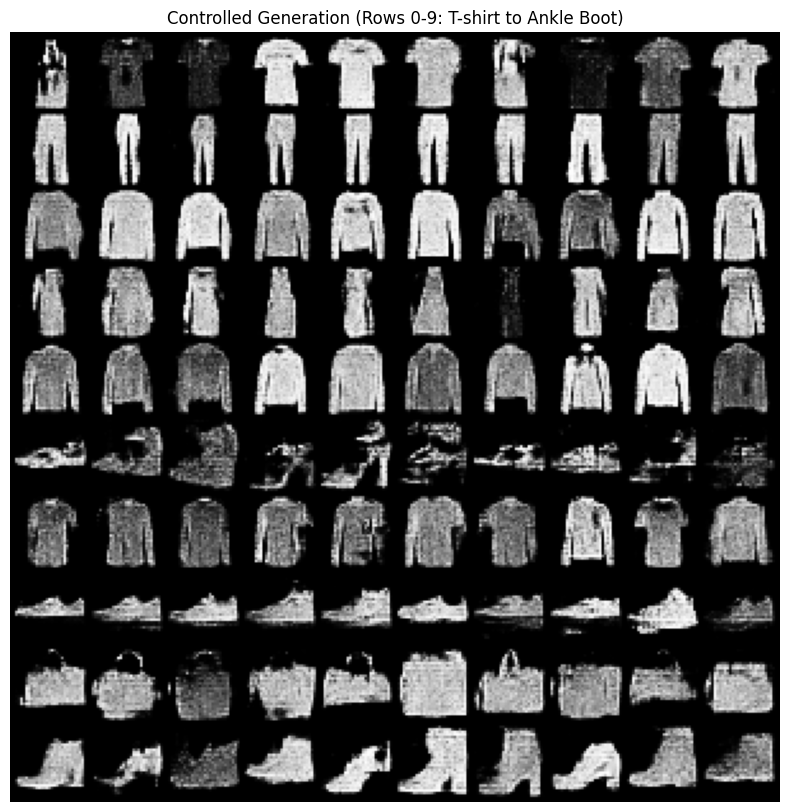

In [5]:
netG.eval()

# Create labels: 0,0,0... 1,1,1... 2,2,2...
# 10 classes, 10 examples each -> 100 images
eval_labels = torch.tensor(
    [i for i in range(num_classes) for _ in range(10)], 
    device=device
)

# Random noise (same noise for each row to see consistency? Or random? Let's use random)
eval_noise = torch.randn(100, z_dim, 1, 1, device=device)

with torch.no_grad():
    generated_imgs = netG(eval_noise, eval_labels)

# Plot
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Controlled Generation (Rows 0-9: T-shirt to Ankle Boot)")
plt.imshow(
    np.transpose(
        vutils.make_grid(generated_imgs, nrow=10, padding=2, normalize=True).cpu(), 
        (1, 2, 0)
    )
)
plt.show()

### Conclusion

You should see a structured grid where every row corresponds to a different clothing item.

**Why is this powerful?**
In a standard GAN, you have to "hunt" in the latent space to find a picture of a sneaker. In a cGAN, you just ask for `class=7` (Sneaker). This makes GANs practical for tools like **Text-to-Image** generation (where the "condition" is the text embedding) or **Image-to-Image** translation (where the "condition" is the input image).